<a href="https://colab.research.google.com/github/yuvarbiv/DQN/blob/main/recreating_Baroch's_article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FUNCTIONS:

In [ ]:
import random
import math
import numpy as np # Import numpy
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


def single_cell_update(grid, i, j, recieved, threshold,target_set,steps):
  """
  This is a function that ...
  """
  distance = np.sqrt((agent_loc[1] - j)**2 + (agent_loc[0] - i)**2)

  P_recieved__t0 = grid[i][j]
  NP_recieved__t0 = 1-P_recieved__t0
  # recieved
  numerator =             P_recieved__t0 * P_ta
  denumerator = numerator + NP_recieved__t0 * P_ta * alpha
  P_signal_recieved__t1 = numerator / denumerator if denumerator != 0 else 0 # Avoid division by zero
  # UNrecieved
  signal_strength = 1-math.e**(-distance/lamda)
  numerator =           P_recieved__t0 * (NP_ta + P_ta*signal_strength)
  denumerator = numerator + NP_recieved__t0 * ((1-alpha*P_ta)+alpha*P_ta*signal_strength)
  P_signal_UNrecieved__t1 = numerator / denumerator if denumerator != 0 else 0 # Avoid division by zero

  if recieved:
    if P_signal_recieved__t1 >= threshold :
      grid[i][j] = 1 # Marking as a definitive target
      if not any (x for x in target_set if x[0] == i and x[1] == j):
        target_set.add((i,j,steps))
        pairs,steps = print_targets_found(target_set)
        return pairs,steps
    else:
      grid[i][j] = P_signal_recieved__t1 # Using the calculated received probability
  else:
    grid[i][j] = P_signal_UNrecieved__t1 # Using the calculated unreceived probability


def single_cell_pulse(agent_loc,targets_loc,false_targets_loc,alpha,i,j) :
  distance = np.sqrt((agent_loc[1] - j)**2 + (agent_loc[0] - i)**2)
  x = math.e**(-distance/lamda)

  if (i, j) in targets_loc :
    return 1 if random.random() < x else 0
  elif (i, j) in false_targets_loc :
    return 1 if random.random() < x*alpha else 0
  else:
    return 0


def print_targets_found(target_tuples):
  pairs = [f"({i}),({j})" for i,j, _ in target_tuples]
  steps = [steps for _, _, steps in target_tuples]

  return pairs,steps


def print_grid():
  plt.clf()  # clear current figure
  plt.imshow(grid, cmap='viridis', vmin=0, vmax=1)
  plt.colorbar()
  plt.title('Probability Map with Agent and Targets')
  plt.xlabel('X')
  plt.ylabel('Y')

  plt.scatter(agent_loc[1], agent_loc[0], color='red', marker='o', s=200, label='Agent')
  targets_x = [loc[1] for loc in targets_loc]
  targets_y = [loc[0] for loc in targets_loc]
  plt.scatter(targets_x, targets_y, color='white', marker='X', s=200, label='Targets')
  false_x = [loc[1] for loc in false_targets_loc]
  false_y = [loc[0] for loc in false_targets_loc]
  plt.scatter(false_x, false_y, color='yellow', marker='X', s=200, label='False Targets')

  plt.legend(loc='upper right')
  plt.pause(0.3)  # short pause to update the plot

#MAIN:

In [ ]:
# 0. Parameters
alpha = 0.5 # [0,1]; 0 - no false alarms, 1 - cannot tell between false & true
lamda = 10 # [0,inf]; sensor strength (in matters of distance)
P_ta = 1 # [0,1]; Target sent a signal ratio. for start, we say that the target sends a signal every step
NP_ta = 1-P_ta # NOT P_ta
nof_iterations = 100
GSize = 10
nof_targets = 3 # nof_targets = random.randint(1,GSize)
threshold = 0.9

# 1. initiate_grid
initial_value = nof_targets/(GSize**2)
grid = np.full((GSize, GSize), initial_value)

# 2. set agent & targets
agent_loc = (0,0)
targets_loc = {(0,1),(2,2),(6,9)}
false_targets_loc = {(0,2),(2,3),(7,9)}
target_set = set();

# 3. set plot
Gfig, Gax = plt.subplots()
Gim = Gax.imshow(grid, cmap='viridis', vmin=0, vmax=1)
Tfig, Tax = plt.subplots()
Tim = Tax.imshow(target_set, cmap='viridis', vmin=0, vmax=1)

def update(frame) :
# 4. iterate to update grid
  for i in range(GSize) :
    for j in range(GSize) :
      recieved = single_cell_pulse(agent_loc,targets_loc,false_targets_loc,alpha,i,j)
      pairs,steps = single_cell_update(grid,i,j,recieved,threshold,target_set,frame)
      if steps > 0 :
        Tim.set_data(pairs,steps)
  Gim.set_data(grid)
  return [Gim],[Tim]

# Add colorbar once
Gcbar = Gfig.colorbar(Gim, ax=Gax)
Gcbar.set_label("Probabillity")
# make animation
Ganim = animation.FuncAnimation(Gfig, update, frames=nof_iterations,blit=True,interval=500)
HTML(Ganim.to_jshtml())

# ChatGPT's Revision:

[[0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
 [0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
 [0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
 [0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
 [0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
 [0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
 [0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
 [0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
 [0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]
 [0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03]]
[(8, 1)]
[(1, 4), (0, 3), (9, 4)]
[(3, 7), (3, 3), (3, 0)]
Press ENTER to continue...


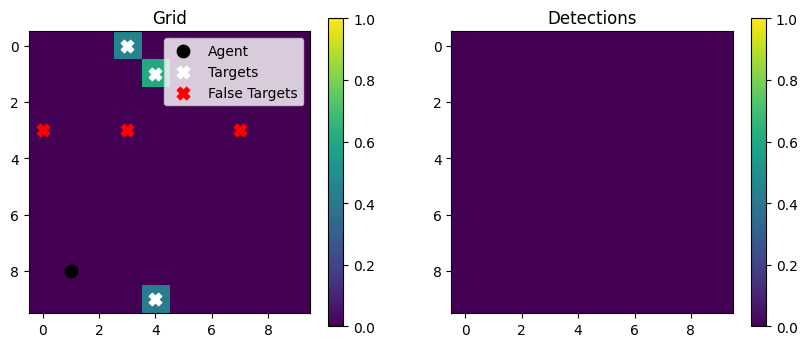

In [ ]:
import random, math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# ----- your model bits (edit as needed) -----
seed = 42
random.seed(seed)
np.random.seed(seed)

alpha = 0.8
lamda = 10
P_ta = 1; NP_ta = 1 - P_ta
nof_iterations = 100
GSize = 10
nof_agents = 1
nof_targets = 3
nof_false_targets = 3
threshold = 0.9

# ----- initialize datasets -----
grid = np.full((GSize, GSize), nof_targets/(GSize**2), dtype=float)
agents_loc = random.sample([(i,j) for i in range(GSize) for j in range(GSize)], nof_agents)
targets_loc = random.sample([(i,j) for i in range(GSize) for j in range(GSize)], nof_targets)
available_locs = [(i,j) for i in range(GSize) for j in range(GSize) if (i,j) not in targets_loc]
false_targets_loc = random.sample(available_locs, nof_false_targets)
print(grid)
print(agents_loc)
print(targets_loc)
print(false_targets_loc)
input("Press ENTER to continue...")

# ----- functions: -----
def cell_send_pulse(targets_loc, false_targets_loc, alpha, i, j):
  # return: 1==pulse, 0==no_pulse
  # later I'd like this function to return continuous value [0,1]
  if (i,j) in targets_loc:        return random.random() < P_ta
  if (i,j) in false_targets_loc:  return random.random() < alpha*P_ta
  return False

def agent_recieved_signal(d, lamda):
  # return: 1==pulse, 0==no_pulse
  # later I'd like this function to return continuous value [0,1]
  x = math.e**(-d/lamda)
  return random.random() < x

def cell_update_probabillity(grid, i, j, recieved, threshold, target_set, frame, d):

  P_recieved__t0 = grid[i][j]
  NP_recieved__t0 = 1-P_recieved__t0
  # recieved
  numerator =             P_recieved__t0 * P_ta
  denumerator = numerator + NP_recieved__t0 * P_ta * alpha
  P_signal_recieved__t1 = numerator / denumerator if denumerator != 0 else 0 # Avoid division by zero
  # UNrecieved
  signal_strength = 1-math.e**(-d/lamda)
  numerator =           P_recieved__t0 * (NP_ta + P_ta*signal_strength)
  denumerator = numerator + NP_recieved__t0 * ((1-alpha*P_ta)+alpha*P_ta*signal_strength)
  P_signal_UNrecieved__t1 = numerator / denumerator if denumerator != 0 else 0 # Avoid division by zero

  if recieved:
    if P_signal_recieved__t1 >= threshold :
      grid[i][j] = 1 # Marking as a definitive target
      if not any (x for x in target_set if x[0] == i and x[1] == j):
        target_set.add((i,j,frame))
        pairs,frame = print_targets_found(target_set)
        return 1
    else:
      grid[i][j] = P_signal_recieved__t1 # Using the calculated received probability
  else:
    grid[i][j] = P_signal_UNrecieved__t1 # Using the calculated unreceived probability

  if grid[i,j] >= threshold and (i,j) not in target_set:
      target_set.add((i,j,frame))
      return 1
  return 0

def print_targets_found(target_tuples):
  pairs = [f"({i}),({j})" for i,j, _ in target_tuples]
  steps = [steps for _, _, steps in target_tuples]
  return pairs,steps

# --------------------------------------------

# ----- Simulation Initialization -----
# A 2D image to visualize detections (instead of trying imshow on a set)
detect_img = np.zeros_like(grid, dtype=float)
target_set = set()

# ---- single figure, two axes ----
fig, (Gax, Tax) = plt.subplots(1, 2, figsize=(10, 4))
Gim = Gax.imshow(grid, cmap='viridis', vmin=0, vmax=1)
Gax.set_title('Grid'); fig.colorbar(Gim, ax=Gax)

Tim = Tax.imshow(detect_img, cmap='viridis', vmin=0, vmax=1)
Tax.set_title('Detections'); fig.colorbar(Tim, ax=Tax)

# draw static markers once
ax = [c[1] for c in agents_loc]; ay = [c[0] for c in agents_loc]
Gax.scatter(ax, ay, marker='o', s=80, color='black', label='Agent')
tx = [c[1] for c in targets_loc]; ty = [c[0] for c in targets_loc]
Gax.scatter(tx, ty, marker='X', s=80, color='white', label='Targets')
fx = [c[1] for c in false_targets_loc]; fy = [c[0] for c in false_targets_loc]
Gax.scatter(fx, fy, marker='X', s=80, color='red', label='False Targets')
Gax.legend(loc='upper right')

# ----- main loop -----
def update(frame):
  # step model once
  # TODO adjust to multiple agents!!!
  for a in agents_loc:
    for i in range(GSize):
      for j in range(GSize):
        d = np.hypot(agents_loc[0][0]-i, agents_loc[0][1]-j)
        s = cell_send_pulse(targets_loc, false_targets_loc, alpha, i, j)
        r = agent_recieved_signal(d, lamda) if s else 0
        target_aqcuired = cell_update_probabillity(grid, i, j, r, threshold, target_set, frame, d)
        if target_aqcuired:
          detect_img[i, j] = frame  # reflect into detection image

  # update both images
  Gim.set_data(grid)
  Tim.set_data(detect_img)
  # return a FLAT list of artists
  return [Gim, Tim]

# ----- run -----
anim = animation.FuncAnimation(fig, update, frames=nof_iterations, interval=200, blit=False)
HTML(anim.to_jshtml())
